import packages that we need

In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf


ImportError: No module named PIL

the create_captcha function creates the basic captcha.  A couple of notes:
1. you will need some font.  You can download fonts and then click to install from http://openfontlibrary.org/en/font
2. I chose Arial for the font, you could choose any font


In [222]:
def create_captcha(text, shear=0, size=(100,24)):
    im = Image.new("L", size, "black")  #black and white pixels
    draw = ImageDraw.Draw(im)  #draws the image
    font = ImageFont.truetype(r"Coval-Black.otf", 22) #here is the font definition
    draw.text((2, 2), text, fill=1, font=font) #now we will draw the text specified
    image = np.array(im)  #convert image to numpy array
    affine_tf = tf.AffineTransform(shear=shear)  #apply shear transform
    image = tf.warp(image, affine_tf) 
    return image / image.max()  #normalize so values are in 0 to 1 range

Generate an image using pyploy

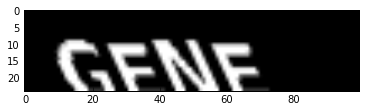

In [223]:
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("GENE", shear=0.5)
plt.imshow(image, cmap="gray")

Splitting the image
We will break this down into predicting letters not words
Let's go ahead and create a function to find sections of black pixels and then extract these as sub-images
We need to import label and regionprops

In [224]:
from skimage.measure import label, regionprops

def segment_image(image):
    labeled_image = label(image > 0)  #finds connected sets of pixels
    subimages = []                    #array for subimages
    for region in regionprops(labeled_image):  #region allows us to work on each part of the image
        start_x, start_y, end_x, end_y = region.bbox  #find starting and ending coordinaes of current region
        subimages.append(image[start_x:end_x, start_y:end_y])  #can extract the region since the image is simply an array
    if len(subimages) == 0:  #if there are no sub-images, return image
        return [image,]
    return subimages

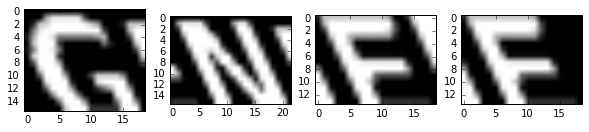

In [225]:
subimages = segment_image(image)  #call function
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))  #plot this so we can see subimages
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

Let's create a training dataset.  We will use a letterset with different shear values.  We will randomly select from this list.  Shear_values is a range from 0 to 0.5 with steps of 0.05

In [24]:
from sklearn.utils import check_random_state
random_state = check_random_state(14)
letters = list("ACBDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)

generate_sample is a function which generates a single sample in our training dataset.  The function randomly select a letter and a shear value from the lists

In [74]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear=shear, size=(20, 20)), letters.index(letter)  #returns Image as well as 
                                                                                      #0 for A, 1 for B, 2 for C, etc.

we now call this function to plot our image

The target for this image is: 7


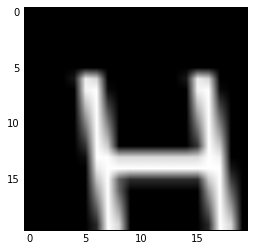

In [118]:
image, target = generate_sample(random_state)
plt.imshow(image, cmap="gray")
print("The target for this image is: {0}".format(target))

let's call this a few thousand times .  Data is stored in numpy arrays

In [120]:
dataset, targets = zip(*(generate_sample(random_state) for i in
range(3000)))
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)
targets

array([ 1,  6, 24, ..., 25, 10, 14])

as you can see, targets is an array with values between 0 and 26, each representing a letter of the alphaet. 
We need to have multiple outputs for each single neurons, each with values of either 0 or 1. We need to hotcode the array, with 26 outputs per sample, near 1 if letter is likely and near 0 otherwise

In [125]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

we need to make this a dense array

In [78]:
y = y.todense()

we now have 20 by 20 pixels images.    Extracting letters from words in the captcha might squash them.  We need to
resize the images in our training dataset to be 20 by 20

In [79]:
from skimage.transform import resize

In [80]:
dataset = np.array([resize(segment_image(sample)[0], (20, 20)) for
sample in dataset])                                                  #segment the sample and resize

In [81]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] *
dataset.shape[2]))                                                   #flatten the dataset to two dimensions from three

we now split our set up so that we have training and testing

In [82]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y, train_size=0.9)

you will need pybrain now (pip3 install pybrain)
We are going to build neural net which will take an image as input and try to predict which single letter is in the image
The single letters will be training data.  20 by 20 pixel image, 1 = black 0 = white.
Think of this as the 400 features that are the inputs.  The output will be 26 values between 0 and 1.  The higher the value, the more likely that the input is the letter

In [83]:
from pybrain.datasets import SupervisedDataSet

we are going to loop through the training dataset and add each row as a sample into a SupervisedDataSet instance

In [84]:
training = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_train.shape[0]):
    training.addSample(X_train[i], y_train[i])

do the same for testing

In [85]:
testing = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_test.shape[0]):
    testing.addSample(X_test[i], y_test[i])

We will create a three-layer network: input, output and hidden.  400 inputs and 26 outputs.  This is dictated by the 
    data.  
    The  number of neurons in hidden layer has to be selected carefully.  Too few and underfitting, two many and 
    overfitting.  We should choose somewhere between input and output, let's go with 100
    
    buildnetwork builds our network for us.  
    1st parameter - # input (features) set to columns in x
    2nd parameter = 100 columns for hidden
    3rd parameter - # outputs
    4th parameter - always use a neuron that activates
    

In [86]:
from pybrain.tools.shortcuts import buildNetwork
net = buildNetwork(X.shape[1], 100, y.shape[1], bias=True)

we will use backpropagation to train the network.  We will start from the output layer and compute which
neurons were incorrect in their predictions.  We will then adjust the weights into those neurons by a small amount
This is an attempt to fix the incorrect predictions.  
Why does this help?  Neurons made mistake because of neurons giving them input.  The weights on connections between neurons and inputs were incorrect.    This is done using learning rate and error rate.  There is a gradient used, which is either positive or negstive.
Start at output and work our way back to input layer
pybrain has a BackpropTrainer implementation of this

In [87]:
from pybrain.supervised.trainers import BackpropTrainer
trainer = BackpropTrainer(net, training, learningrate=0.01,
weightdecay=0.01)

we could either run this until the error rate is very low or a set number of times

In [88]:
trainer.trainEpochs(epochs=20)

we can now run predictions on this.  We can the produce an F-score on this.

In [126]:
predictions = trainer.testOnClassData(dataset=testing)

In [127]:
from sklearn.metrics import f1_score
print("F-score: {0:.2f}".format(f1_score(predictions, y_test.argmax(axis=1),average='weighted')))

F-score: 0.88


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [91]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        12
          1       1.00      0.45      0.62        11
          2       1.00      0.92      0.96        12
          3       1.00      1.00      1.00        13
          4       0.70      0.70      0.70        10
          5       0.77      0.77      0.77        13
          6       1.00      1.00      1.00         9
          7       1.00      1.00      1.00        13
          8       0.56      1.00      0.72        19
          9       0.00      0.00      0.00         9
         10       1.00      1.00      1.00         5
         11       0.00      0.00      0.00         6
         12       1.00      1.00      1.00        13
         13       1.00      1.00      1.00        14
         14       0.39      1.00      0.56        11
         15       0.80      1.00      0.89        16
         16       0.00      0.00      0.00        11
         17       1.00      0.67      0.80   

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


now that we can predict letters, we can start to look at words.  Function will accept a captcha and our trained neural network.  Will return predicted word

In [70]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)   #extract sub-images
    predicted_word = ""
    for subimage in subimages:  #iterate over subimages
        subimage = resize(subimage, (20, 20)) #resize
        outputs = net.activate(subimage.flatten()) #activate neural net
        prediction = np.argmax(outputs) #find highest prediction for one of the letters
        predicted_word += letters[prediction] #get this from the array
    return predicted_word #return the predicted work

now let's test

In [130]:
word = "GENE"
captcha = create_captcha(word, shear=0.2)
print(predict_captcha(captcha, net))

OUNU


write a function to use this more easily

In [129]:
def test_prediction(word, net, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    return word == prediction, word, prediction

In [138]:
print(test_prediction("EARL",net))

(False, 'EARL', 'HU')


we can test this with a whole bunch of words
to get corpus you might need to run nltk.download() and then select words

In [132]:
from nltk.corpus import words

In [101]:
valid_words = [word.upper() for word in words.words() if len(word) == 4] #find all 4 letter words that are capital

In [139]:
#we will run this through all the valid words
num_correct = 0
num_incorrect = 0
for word in valid_words:
    correct, word, prediction = test_prediction(word, net, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1

In [103]:
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 65
Number incorrect is 5448


In [104]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

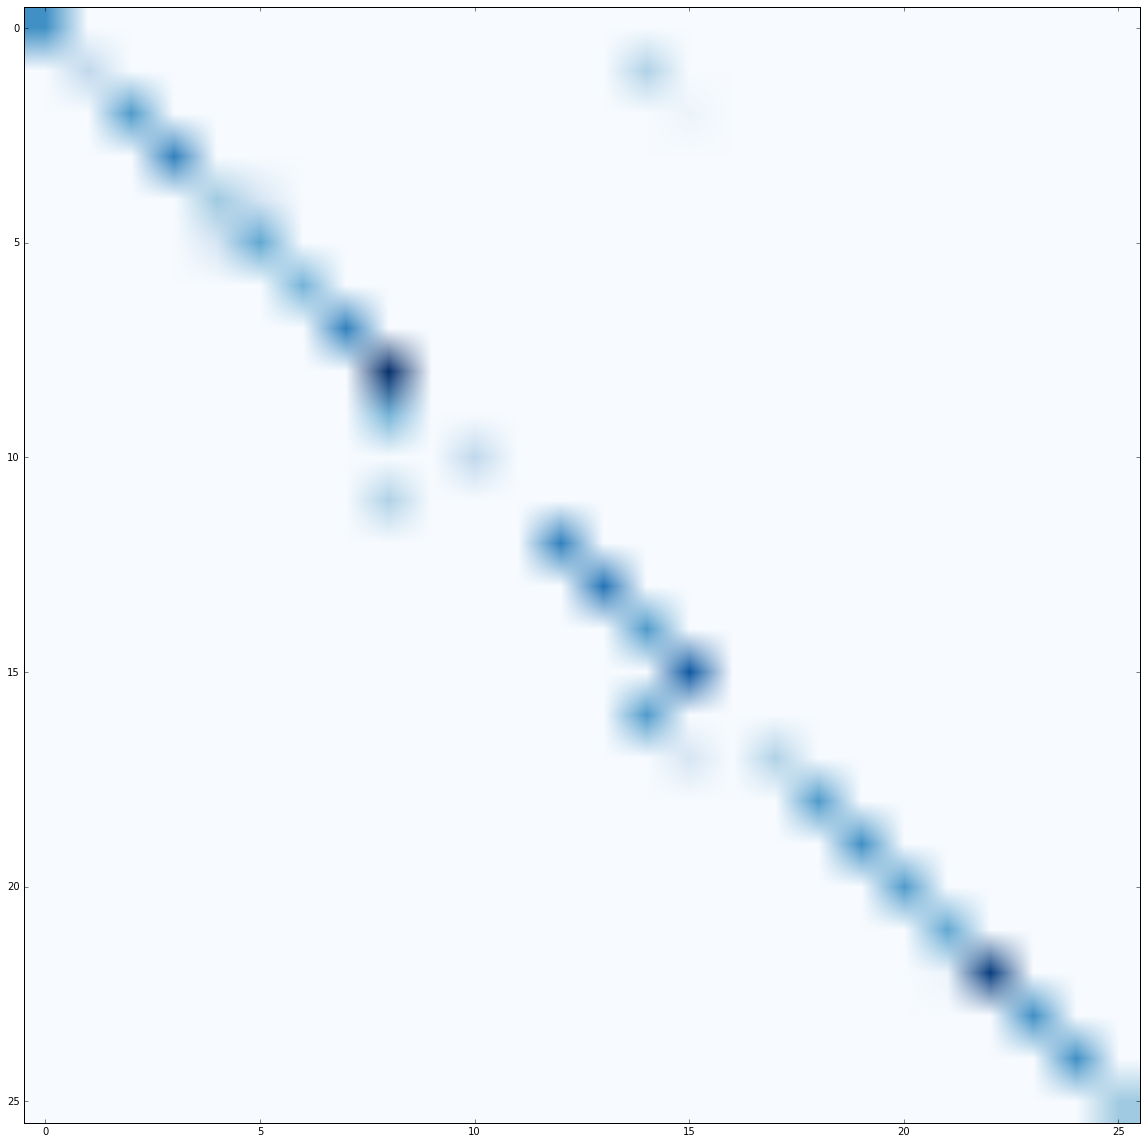

In [105]:
plt.figure(figsize=(20,20))
plt.imshow(cm, cmap="Blues")

We can use a distance function to compare two short strings.  Levenshtein edit distance 
1. insert new letter into the word at any position
2. delete any letter from the word
3. substitute a letter for another one

Maximum # of steps actions needed to tranform first word into second is the distance.  Higher number, less similar

In [189]:
from nltk.metrics import edit_distance
steps = edit_distance("STEP", "STOP")
print("The number of steps needed is: {0}".format(steps))

The number of steps needed is: 2


This is not the best for our case here.  Instead, our distance function is number of letters in same position that are
incorrect

In [107]:
def compute_distance(prediction, word):
    return len(prediction) - sum(prediction[i] == 
                                 word[i] for i in range(len(prediction)))

In [108]:
from operator import itemgetter
def improved_prediction(word, net, dictionary, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word))
                            for word in dictionary],
                           key=itemgetter(1))
        best_word = distances[0]  #find best matching word
        prediction = best_word[0]
    return word == prediction, word, prediction

In [109]:
num_correct = 0
num_incorrect = 0
for word in valid_words:
    correct, word, prediction = improved_prediction (word, net, valid_words, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 190
Number incorrect is 5323
